<a href="https://colab.research.google.com/github/ShangWeiKuo/Portfolio/blob/main/Python/Classification/Multiclass/Wafer/Wafer_classification_EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 讀取 libraries
import numpy as np 
from numpy import argmax
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import layers, Input, models
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB7
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = np.load('/content/drive/MyDrive/wafer/rawdata.npz')
X_data = df['X_data']
y_data = df['y_data']

In [ ]:
# 資料切割 (80% = Train, 20% = Test)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=2021)

In [ ]:
# 模型架構 (EfficientNet-B7)
def build_densenet():
    EfficientNet = EfficientNetB7(weights='imagenet', include_top=False)

    input = Input(shape=(64, 64, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = EfficientNet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(8, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
# 呼叫模型
model = build_densenet()
# EarlyStopping：可設定訓練提早結束的條件。
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=10)
# ReduceLROnPlateau：當訓練已無改善時，可以降低學習率，追求更細微的改善，找到更精準的最佳解。
Reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# ModelCheckpoint：由於訓練過程耗時，有可能訓練一半就當掉，因此，我們可以利用這個 Callback，在每一個檢查點(Checkpoint)存檔，下次執行時，就可以從中斷點繼續訓練。
checkpoint = ModelCheckpoint('wafer_detection_densenet_model.h5', verbose=1, save_best_only=True)

# 訓練資料
History = model.fit(new_X_train, new_y_train, 
           epochs=100, 
           batch_size=64,
           verbose=2,
           callbacks=[Reduce, es, checkpoint],
           validation_split=0.2, # 每次訓練將 Train data 分割 20% 作為 Validation data
           workers=8)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2560)              0     

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


256/256 - 248s - loss: 3.2001 - accuracy: 0.1542 - val_loss: 2.2619 - val_accuracy: 0.1609 - lr: 1.0000e-04 - 248s/epoch - 968ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 2.26186 to 2.23371, saving model to wafer_detection_densenet_model.h5
256/256 - 201s - loss: 2.6326 - accuracy: 0.2448 - val_loss: 2.2337 - val_accuracy: 0.1639 - lr: 1.0000e-04 - 201s/epoch - 787ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 2.23371 to 1.81650, saving model to wafer_detection_densenet_model.h5
256/256 - 195s - loss: 2.1712 - accuracy: 0.3606 - val_loss: 1.8165 - val_accuracy: 0.3554 - lr: 1.0000e-04 - 195s/epoch - 762ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 1.81650 to 1.18415, saving model to wafer_detection_densenet_model.h5
256/256 - 195s - loss: 1.8463 - accuracy: 0.4527 - val_loss: 1.1842 - val_accuracy: 0.6084 - lr: 1.0000e-04 - 195s/epoch - 761ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 1.18415 to 0.94015, saving model to wafer_detection_densen

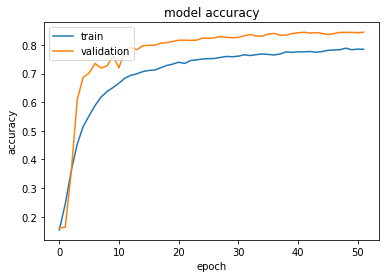

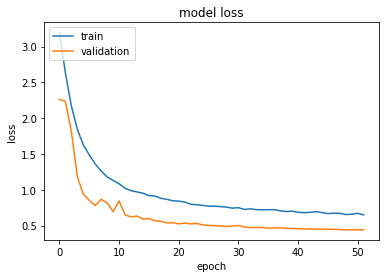

In [ ]:
# Accuracy plot 
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluation
score = model.evaluate(new_X_test, new_y_test)
print('Test Accuracy:', score[1])

160/160 [==============================] - 24s 146ms/step - loss: 0.4247 - accuracy: 0.8460
Test Accuracy: 0.8460031151771545


In [ ]:
# 預測 Test data
predictions = model.predict(new_X_test)
predictions = np.argmax(predictions, axis=1)

In [ ]:
# 取出真實值類別
true = np.argmax(new_y_test, axis=1)

In [ ]:
# 混淆矩陣 (Confusion Matrix)
print(classification_report(true, predictions))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       831
           1       0.87      0.69      0.77       110
           2       0.71      0.85      0.77      1083
           3       0.95      0.95      0.95      1924
           4       0.74      0.64      0.68       718
           5       0.85      0.74      0.79       171
           6       0.68      0.38      0.48       234
           7       0.74      0.85      0.79        33

    accuracy                           0.85      5104
   macro avg       0.81      0.76      0.77      5104
weighted avg       0.85      0.85      0.84      5104



In [ ]:
# 將預測值轉換為二進位的矩陣向量
onehot_encoder = OneHotEncoder(sparse=False)
predictions = predictions.reshape(len(predictions), 1)
predictions = onehot_encoder.fit_transform(predictions)

In [ ]:
# 同上
onehot_encoder = OneHotEncoder(sparse=False)
true = true.reshape(len(true), 1)
true = onehot_encoder.fit_transform(true)

In [ ]:
# 計算 AUC 值
test_auc = roc_auc_score(true, predictions)

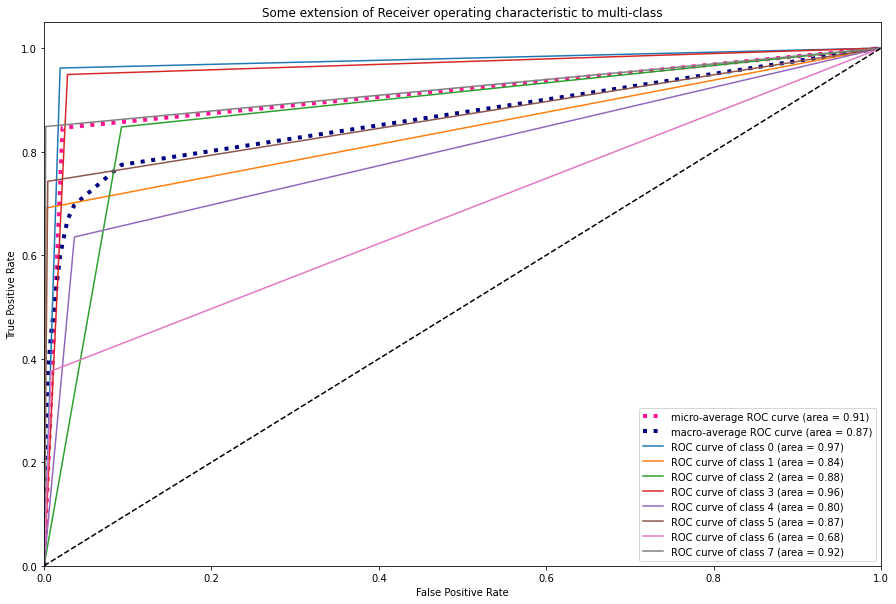

In [ ]:
# ROC 圖
n_classes = 8

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(true[:, i], predictions[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(true.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(15, 10))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i in range(n_classes):
  plt.plot(fpr[i], tpr[i],
      label='ROC curve of class {0} (area = {1:0.2f})'
      ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()